In [9]:
import torch

print("torch version:", torch.__version__)

torch version: 2.5.1


In [21]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random

# 랜덤 시드 고정
torch.manual_seed(42)
random.seed(42)

# 데이터 경로
TRAIN_PATH = "/home/kangkr1002/facial_bone/Training"
VAL_PATH   = "/home/kangkr1002/facial_bone/Validation"
TEST_PATH  = "/home/kangkr1002/facial_bone/Test"

# 공통으로 사용할 transform 정의
transform = transforms.Compose([
    transforms.Resize((380, 380)),   # 380x380 크기 조정
    transforms.ToTensor(),           # Tensor로 변환
])

# 데이터셋 만들기
train_ds = datasets.ImageFolder(root=TRAIN_PATH, transform=transform)
val_ds   = datasets.ImageFolder(root=VAL_PATH, transform=transform)
test_ds  = datasets.ImageFolder(root=TEST_PATH, transform=transform)

# DataLoader로 배치 만들기
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=True)


In [22]:
import torch
import torch.nn as nn
from torchvision import models

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# EfficientNet-B4 불러오기 (pretrained=True: ImageNet으로 사전학습된 가중치 사용)
model = models.efficientnet_b4(pretrained=False)

# 마지막 출력층 수정 (네 데이터셋 클래스 수에 맞게)
num_classes = len(train_ds.classes)  # ImageFolder가 자동으로 class 인식
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# 모델 디바이스에 올리기
model = model.to(device)

# (참고) Optimizer, Loss 설정 예시
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/home/kmj388/micromamba/envs/capston-pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kmj388/micromamba/envs/capston-pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [23]:
import mlflow
num_epochs = 10
mlflow.set_tracking_uri("http://10.125.208.184:5000")
with mlflow.start_run(run_name="effcientnetb4_4"):  # 전체 학습을 하나의 run으로 묶는다
    mlflow.log_param("learning_rate", optimizer.param_groups[0]['lr'])
    mlflow.log_param("batch_size", train_loader.batch_size)
    mlflow.log_param("num_epochs", num_epochs)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # 검증(validation)
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        # 👉 에폭마다 train/val 결과 기록
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/10] | Train Loss: 0.5421, Train Acc: 0.7147 | Val Loss: 0.3553, Val Acc: 0.8440
Epoch [2/10] | Train Loss: 0.3333, Train Acc: 0.8563 | Val Loss: 0.2501, Val Acc: 0.8940
Epoch [3/10] | Train Loss: 0.2249, Train Acc: 0.9081 | Val Loss: 0.1275, Val Acc: 0.9490
Epoch [4/10] | Train Loss: 0.1625, Train Acc: 0.9376 | Val Loss: 0.1245, Val Acc: 0.9550
Epoch [5/10] | Train Loss: 0.1218, Train Acc: 0.9528 | Val Loss: 0.0862, Val Acc: 0.9680
Epoch [6/10] | Train Loss: 0.0998, Train Acc: 0.9627 | Val Loss: 0.0730, Val Acc: 0.9720
Epoch [7/10] | Train Loss: 0.0725, Train Acc: 0.9743 | Val Loss: 0.0896, Val Acc: 0.9710
Epoch [8/10] | Train Loss: 0.0703, Train Acc: 0.9744 | Val Loss: 0.0670, Val Acc: 0.9740
Epoch [9/10] | Train Loss: 0.0552, Train Acc: 0.9799 | Val Loss: 0.0929, Val Acc: 0.9700
Epoch [10/10] | Train Loss: 0.0496, Train Acc: 0.9821 | Val Loss: 0.0976, Val Acc: 0.9710
🏃 View run effcientnetb4_4 at: http://10.125.208.184:5000/#/experiments/0/runs/7f4ca1cbb388426eab74aac7de3235

In [24]:
#모델 저장 pth
torch.save(model.state_dict(), 'efficientnet_b4_facial_bone.pth')

In [ ]:
mlflow.pytorch.log_model(model, artifact_path="model")  # PyTorch 기준

2025/04/26 16:30:25 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'mathmodule'}
2025/04/26 16:30:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [25]:
# model test with test_ds
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
test_loss = test_loss / test_total
test_acc = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.1565, Test Acc: 0.9660


In [30]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


2025/04/26 22:31:17 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'mathmodule'}
2025/04/26 22:31:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'efficientnetb4' already exists. Creating a new version of this model...
2025/04/26 22:31:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: efficientnetb4, version 4
Created version '4' of model 'efficientnetb4'.


🏃 View run effcientnetb4_4 at: http://10.125.208.184:5000/#/experiments/0/runs/7f4ca1cbb388426eab74aac7de32354d
🧪 View experiment at: http://10.125.208.184:5000/#/experiments/0


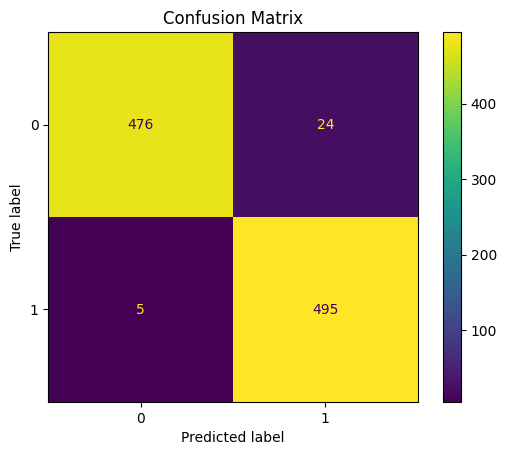

In [31]:
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import torch
import json

# ===== 설정 =====
mlflow.set_tracking_uri("http://10.125.208.184:5000")
run_id = "7f4ca1cbb388426eab74aac7de32354d"  # 네 훈련했던 run_id

# ===== 현재 열린 run 있으면 닫기 =====
if mlflow.active_run():
    mlflow.end_run()

# ===== 기존 run 이어서 열기 =====
with mlflow.start_run(run_id=run_id):

    # 1. 모델 저장 + Model Registry 등록
    mlflow.pytorch.log_model(model, artifact_path="model")
    model_uri = f"runs:/{run_id}/model"
    mlflow.register_model(model_uri=model_uri, name="efficientnetb4")

    # 2. Confusion Matrix 저장
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # 3. Classification Report 저장
    cls_report = classification_report(all_labels, all_preds, output_dict=True)
    with open("classification_report.json", "w") as f:
        json.dump(cls_report, f, indent=4)
    mlflow.log_artifact("classification_report.json")


In [27]:
# ===== 테스트 시작 =====
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:   # ✅ 반드시 test_loader 필요
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)

        test_total += labels.size(0)
        test_correct += preds.eq(labels).sum().item()

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss = test_loss / test_total
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.1565, Test Accuracy: 0.9660


🏃 View run effcientnetb4_4 at: http://10.125.208.184:5000/#/experiments/0/runs/7f4ca1cbb388426eab74aac7de32354d
🧪 View experiment at: http://10.125.208.184:5000/#/experiments/0


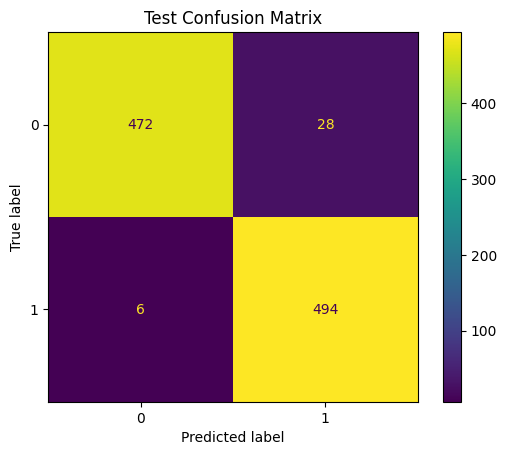

In [28]:
import mlflow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import json

# ===== mlflow 이어서 기록 =====
mlflow.set_tracking_uri("http://10.125.208.184:5000")
run_id = "7f4ca1cbb388426eab74aac7de32354d"

if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_id=run_id):
    # 1. 테스트 결과 메트릭 기록
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)

    # 2. Confusion Matrix
    cm = confusion_matrix(test_labels, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Test Confusion Matrix')
    plt.savefig("test_confusion_matrix.png")
    mlflow.log_artifact("test_confusion_matrix.png")

    # 3. Classification Report
    cls_report = classification_report(test_labels, test_preds, output_dict=True)
    with open("test_classification_report.json", "w") as f:
        json.dump(cls_report, f, indent=4)
    mlflow.log_artifact("test_classification_report.json")


In [15]:
model = torch.load("efficientnet_b4_facial_bone.pth")

/home/kmj388/capston/ipykernel_635786/4166768975.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("efficientnet_b4_facial_bone.pth")


In [16]:
from PIL import Image
import torch

# (이미 앞에서 만든) transform 그대로 사용
# transform = transforms.Compose([...])
# transform 정의 (RGB 강제 변환 추가)
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# transform
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((380, 380)),
    transforms.ToTensor()
])

# 모델도 디바이스로 이동
model = model.to(device)
# 불러오고 싶은 이미지 경로
image_path = "/home/kangkr1002/facial_bone/Test/Abnormal/Facial_bone_Abnormal_00000173.png"

# 1. 이미지 열기
image = Image.open(image_path)

# 2. transform 적용
input_tensor = transform(image)  # (1, 380, 380)

# 3. 모델에 넣기 위해 배치 차원 추가
input_tensor = input_tensor.unsqueeze(0)  # (1, 1, 380, 380) 또는 (1, 3, 380, 380) (채널 수에 따라 다름)

# 4. 모델에 넣고 예측
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1)
    print(f"예측 결과: {pred.item()}")


AttributeError: 'collections.OrderedDict' object has no attribute 'to'

In [17]:
from torchvision.models import efficientnet_b4

# 1. 모델 아키텍처 선언
model = efficientnet_b4(pretrained=False, num_classes=2)  # 💥 num_classes=2 (네 프로젝트에 맞춰)


/home/kmj388/micromamba/envs/capston-pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kmj388/micromamba/envs/capston-pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
# 2. 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 3. 저장한 가중치 불러오기
state_dict = torch.load('/home/kmj388/capston/efficientnet_b4_facial_bone.pth', map_location=device)

# 4. 모델에 가중치 적용
model.load_state_dict(state_dict)

# 5. 이제 모델을 써서 예측


/home/kmj388/capston/ipykernel_635786/2094987660.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/home/kmj388/capston/efficientnet_b4_facial_bon

<All keys matched successfully>

In [19]:

# Transform 정의
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((380, 380)),
    transforms.ToTensor()
])

# 테스트할 이미지 경로
image_path = "/home/kangkr1002/facial_bone/Test/Abnormal/Facial_bone_Abnormal_00000173.png"

# 이미지 불러오기 및 전처리
image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0).to(device)

# 모델 예측
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1)
    print(f"예측 결과: {pred.item()}")

예측 결과: 0
